In [49]:
suppressPackageStartupMessages({
library(tidyverse)
library(tidymodels)
library(survival)
library(cowplot)
library(future)
library(furrr)
library(censored)
library(shapviz)
library(fastshap)
})
theme_set(theme_cowplot())
options(repr.plot.width = 15, repr.plot.height = 9)
set.seed(42)

In [2]:
# the multi model fitting process will use multiple cores
plan(multicore, workers = 6)

# Survival prediction models, part 2

In part 1 we learned how to train different survival models and compare them with the concordance index.

However there are other survival metrics that we might want to consider, depending on the context,
in this notebook we will explore these metrics.

# Dataset preprocessing

This time we will use the `censored::time_to_million` dataset:

In [3]:
head(time_to_million)

title,time,event,released,released_theaters,distributor,year,rated,runtime,action,⋯,mandarin,usa,india,mexico,uk,france,china,canada,japan,australia
<chr>,<dbl>,<dbl>,<date>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10 Cloverfield Lane,0.111342778318533,1,2016-03-11,3427,paramount_pi,2016,pg_13,103,1,⋯,0,1,0,0,0,0,0,0,0,0
102 Not Out,10.654971015124438,1,2018-05-04,102,sony_pictures,2018,pg,102,0,⋯,0,0,1,0,0,0,0,0,0,0
12 Strong,0.176278921201207,1,2018-01-19,3018,warner_bros,2018,r,130,1,⋯,0,1,0,0,0,0,0,0,0,0
3 idiotas,9.406626540687972,1,2017-06-02,349,lionsgate,2017,pg_13,106,0,⋯,0,0,0,1,0,0,0,0,0,0
47 Meters Down,0.228973007974901,1,2017-06-16,2471,entertainmen,2017,pg_13,89,0,⋯,0,0,0,0,1,0,0,0,0,0
7 Days in Entebbe,1.713170877091160,1,2018-03-16,838,focus_features,2018,pg_13,107,1,⋯,0,1,0,0,1,1,0,0,0,0


In [4]:
data <- 
    # remove rows with missing data
    na.omit(time_to_million) |> 
    # the surv variable will be our outcome
    mutate(surv=Surv(time, event)) 
dim(data)

[1] 551  50

In [5]:
# separate 20% of the dataset for testing the models later
data_split <- initial_split(data, prop = 0.8, strata=time)

In [6]:
# create a recipe, to prepare the data for fitting
rec <- recipe(surv ~ ., data=data) |>
    # remove uneeded variables
    step_rm(time, event, title, released) |> 
    # convert factors to integers
    step_integer(all_nominal_predictors()) |>
    # remove variables with zero variance
    step_zv(all_predictors()) |>
    # center and scale all numeric variables
    step_normalize(all_numeric_predictors())

# Model definitions

In [7]:
models <- list(
    cox_ph_survival = proportional_hazards(engine='survival'),
    cox_ph_glmnet = proportional_hazards(penalty=tune(), mixture=tune(), engine='glmnet'),
    survreg_flexsurv = survival_reg(engine='flexsurv'),
    rand_forest_partykit = rand_forest(trees = tune(), engine='partykit'),
    rand_forest_aorsf = rand_forest(trees = tune(), engine='aorsf'),
    decision_tree_partykit = decision_tree(engine='partykit'),
    boost_tree_mboost = boost_tree(trees = tune(), engine='mboost')
) |>
map(~set_mode(.x,'censored regression'))

In [8]:
wsets <- workflow_set(
    preproc=list(rec),
    models=models
)

# Model fitting

In [9]:
# 5-fold cross-validation resampling for the tunning and comparisons
folds <- vfold_cv(training(data_split), v=5, strata=time)

Some metrics are only evaluated at specific time points, for example, 

you might be interested in a model that can predict 1-year survival of cancer patients undergoing a treatment,

so its always important to consider the question you want to answer.

Here we will partition the time points with quantiles, but we could have used equally spaced time points instead, depends on your data.

In [10]:
eval_time_points <-
    with(training(data_split), 
         quantile(time, p=seq(0.01, 0.99, length.out = 20))
    )
eval_time_points

1%           6.157895%           11.31579%           16.47368% 
 0.0151560308243856  0.0424028085643098  0.0654215224706485  0.0910562799996761 
          21.63158%           26.78947%           31.94737%           37.10526% 
 0.1091091052567204  0.1408918770155651  0.1728922079602689  0.2003546109416434 
          42.26316%           47.42105%           52.57895%           57.73684% 
 0.2336669443961094  0.2648610033836038  0.3330964013351638  0.4298839809924025 
          62.89474%           68.05263%           73.21053%           78.36842% 
 0.5972929772563629  0.7389478684453571  1.1485942658590811  1.7259227487973385 
          83.52632%           88.68421%           93.84211%                 99% 
 2.6260027370129460  7.1830905968914731 10.7500402599577676 42.0000000000000000

In [11]:
res <- workflow_map(
    wsets,
    "tune_grid",
    seed = 42,
    grid = 5,
    resamples = folds,
    # these metrics will be calculated for each fit
    metrics=metric_set(brier_survival_integrated, brier_survival, roc_auc_survival, concordance_survival),
    # some metrics are evaluated at specific time points
    eval_time = eval_time_points
)

In [12]:
tune_metrics <- collect_metrics(res)

This time we added more metrics to evaluate, each metric is calculated differently, 
its important to understand how each of these metrics work and what you want to predict in order to choose the best metric for your data:

* [roc_auc](https://yardstick.tidymodels.org/reference/roc_auc_survival.html): measures the area under the ROC curve for each of the chosen time points
* [brier_score](https://yardstick.tidymodels.org/reference/brier_survival.html): mean squared error for each time points, lower is better.
* [concordance index](https://yardstick.tidymodels.org/reference/concordance_survival.html): measures if the time predictions are concordant (events are ordered correctly)
* [integrated brier](https://yardstick.tidymodels.org/reference/brier_survival_integrated.html): summary of the brier score over all given time points, lower is better.

[[1]]

[[2]]


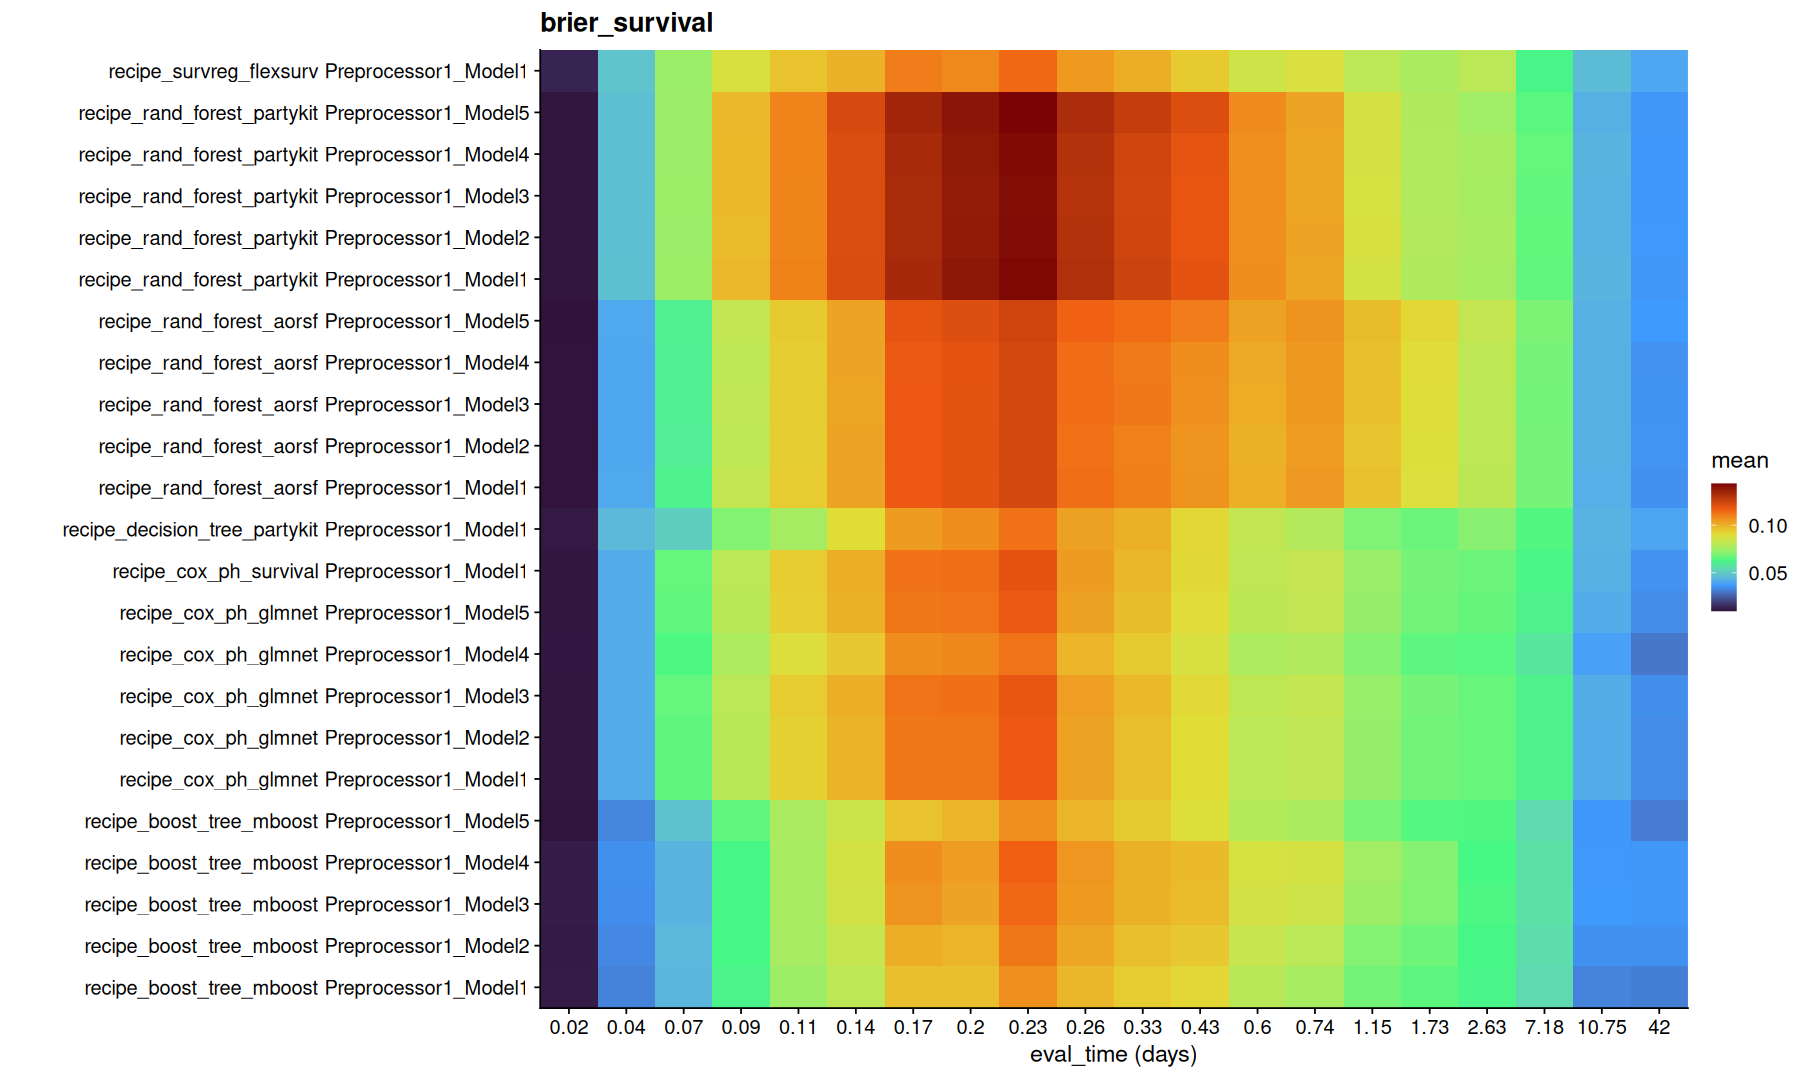

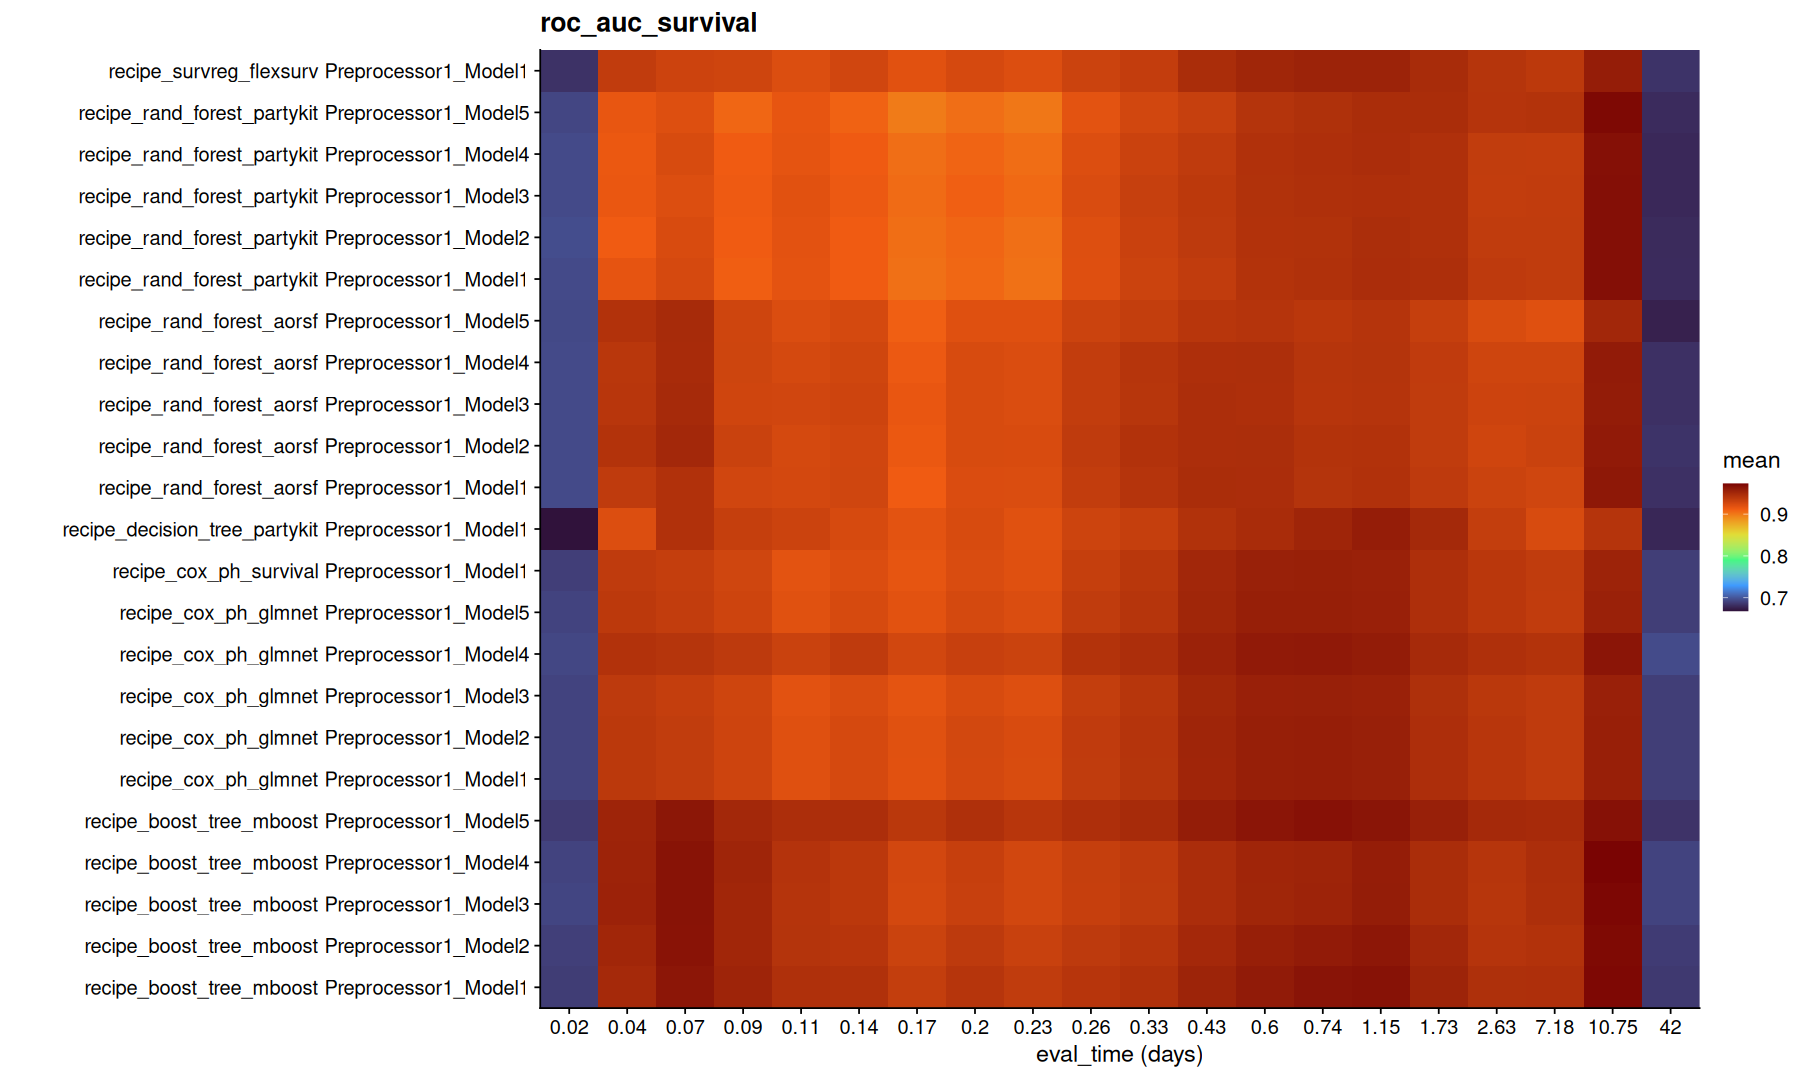

In [13]:
tune_metrics |>
filter(!is.na(.eval_time)) |>
group_by(.metric) |>
group_map(function(df, g) {
    ggplot(df,aes(x=factor(round(.eval_time,2)), y=paste(wflow_id, .config), fill=mean)) +
    geom_tile() +
    coord_cartesian(expand=0) +
    scale_fill_viridis_c(option='turbo') + labs(title=g, x='eval_time (days)', y='')
}) 

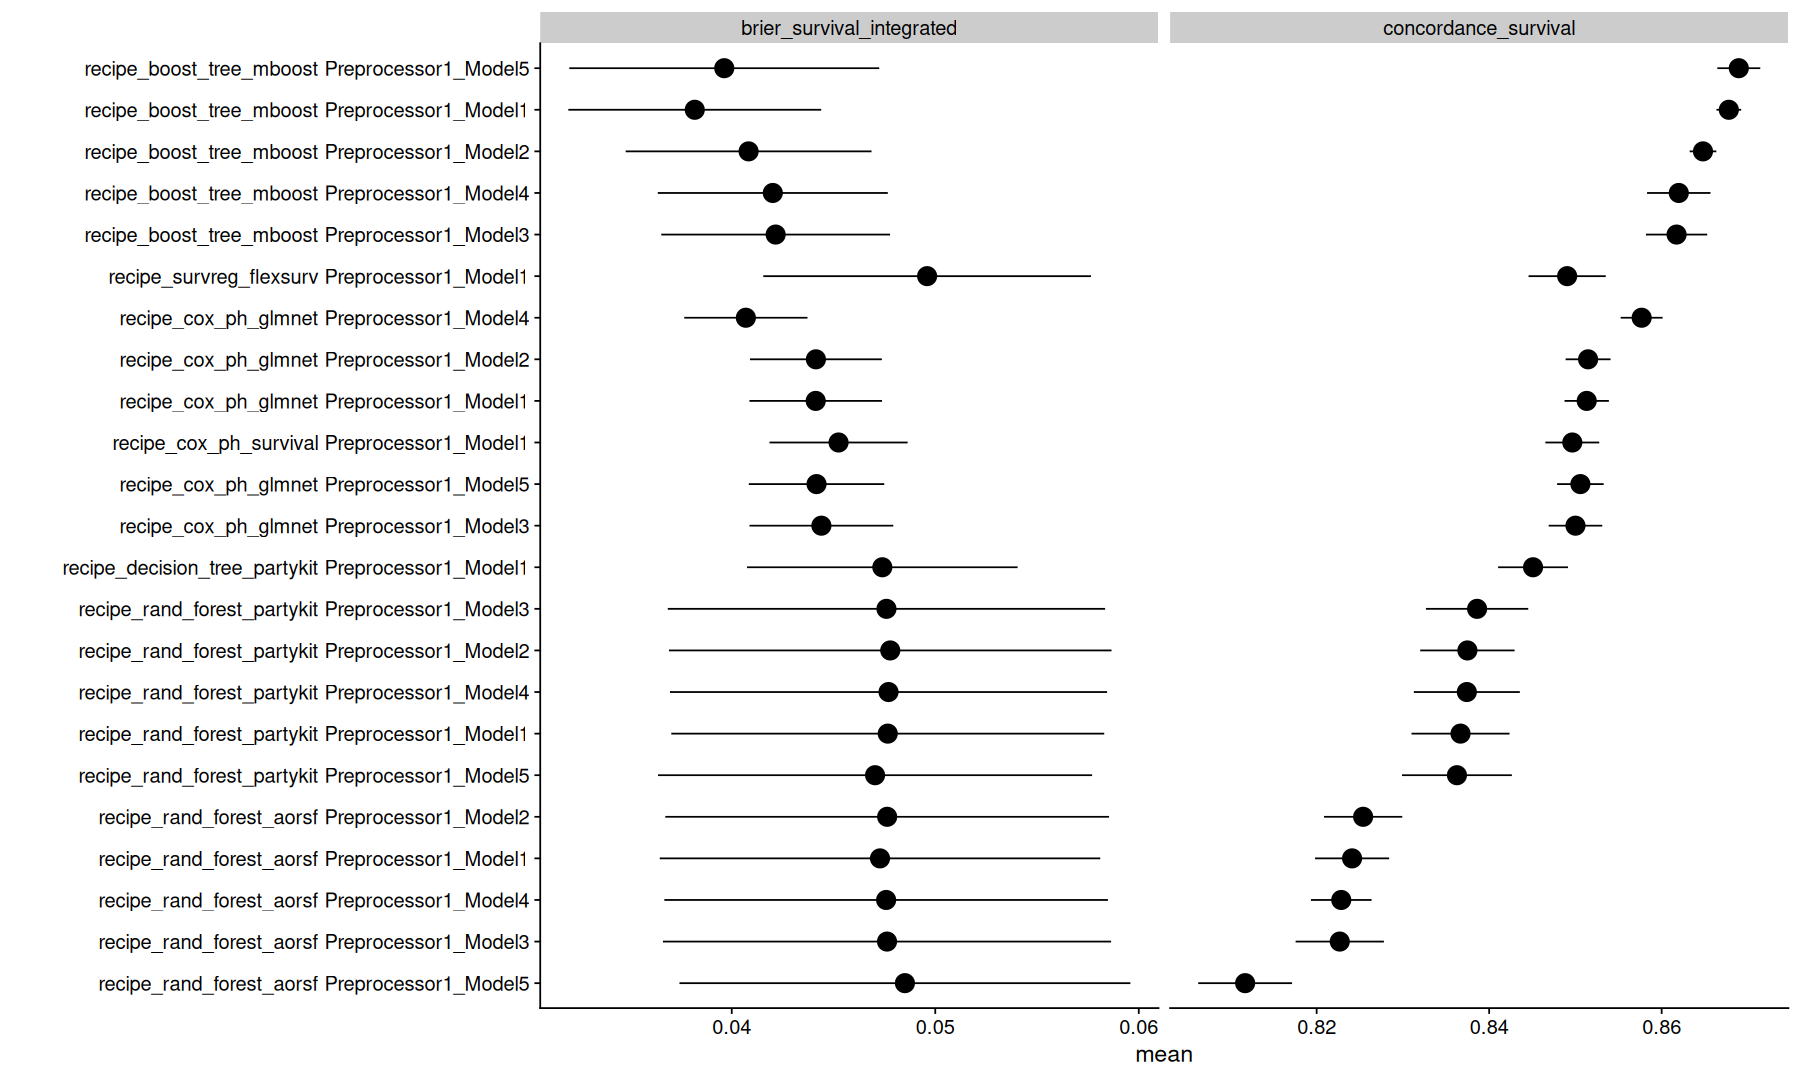

In [14]:
tune_metrics |>
filter(is.na(.eval_time)) |>
arrange(.metric, mean) |>
ggplot(aes(y=fct_reorder(paste(wflow_id, .config), mean), x=mean)) +
geom_point(size=5) +
geom_pointrange(aes(xmin=mean-std_err, xmax=mean+std_err)) +
facet_wrap(~.metric, scales='free_x') +
labs(y='')

Note that, the model with lowest integrated brier might not necessarly be the same as the model with highest concordance.

Again, its important to understand the difference between these metrics to decide which metric is better to optimize.

# Fit the best models with all the training data

In [29]:
final_fits <- 
    # map across each model in the table above
    set_names(unique(tune_metrics$wflow_id)) |>
    future_map(function(wi) {
        # select the best model config, in case of tunnable parameters
        bwr <- extract_workflow_set_result(res, wi)
        best_params <- select_best(bwr, metric='concordance_survival')
        bw <- finalize_workflow(
            extract_workflow(res, wi), 
            best_params
        )
    
        # re-fit the best config with the initial 80% train / 20% test
        fit <- last_fit(
            bw,
            split = data_split,
            metrics = metric_set(brier_survival_integrated, brier_survival, roc_auc_survival, concordance_survival),
            eval_time = eval_time_points
        )

        metrics <- collect_metrics(fit) |>
        mutate(wflow_id = wi, .config = best_params$.config)

        list(fit=list(fit), metrics=metrics)
    }, .options = furrr_options(seed = T)) |>
    list_transpose()

Joining with `by = join_by(.metric, .estimator, .eval_time, .config, wflow_id)`


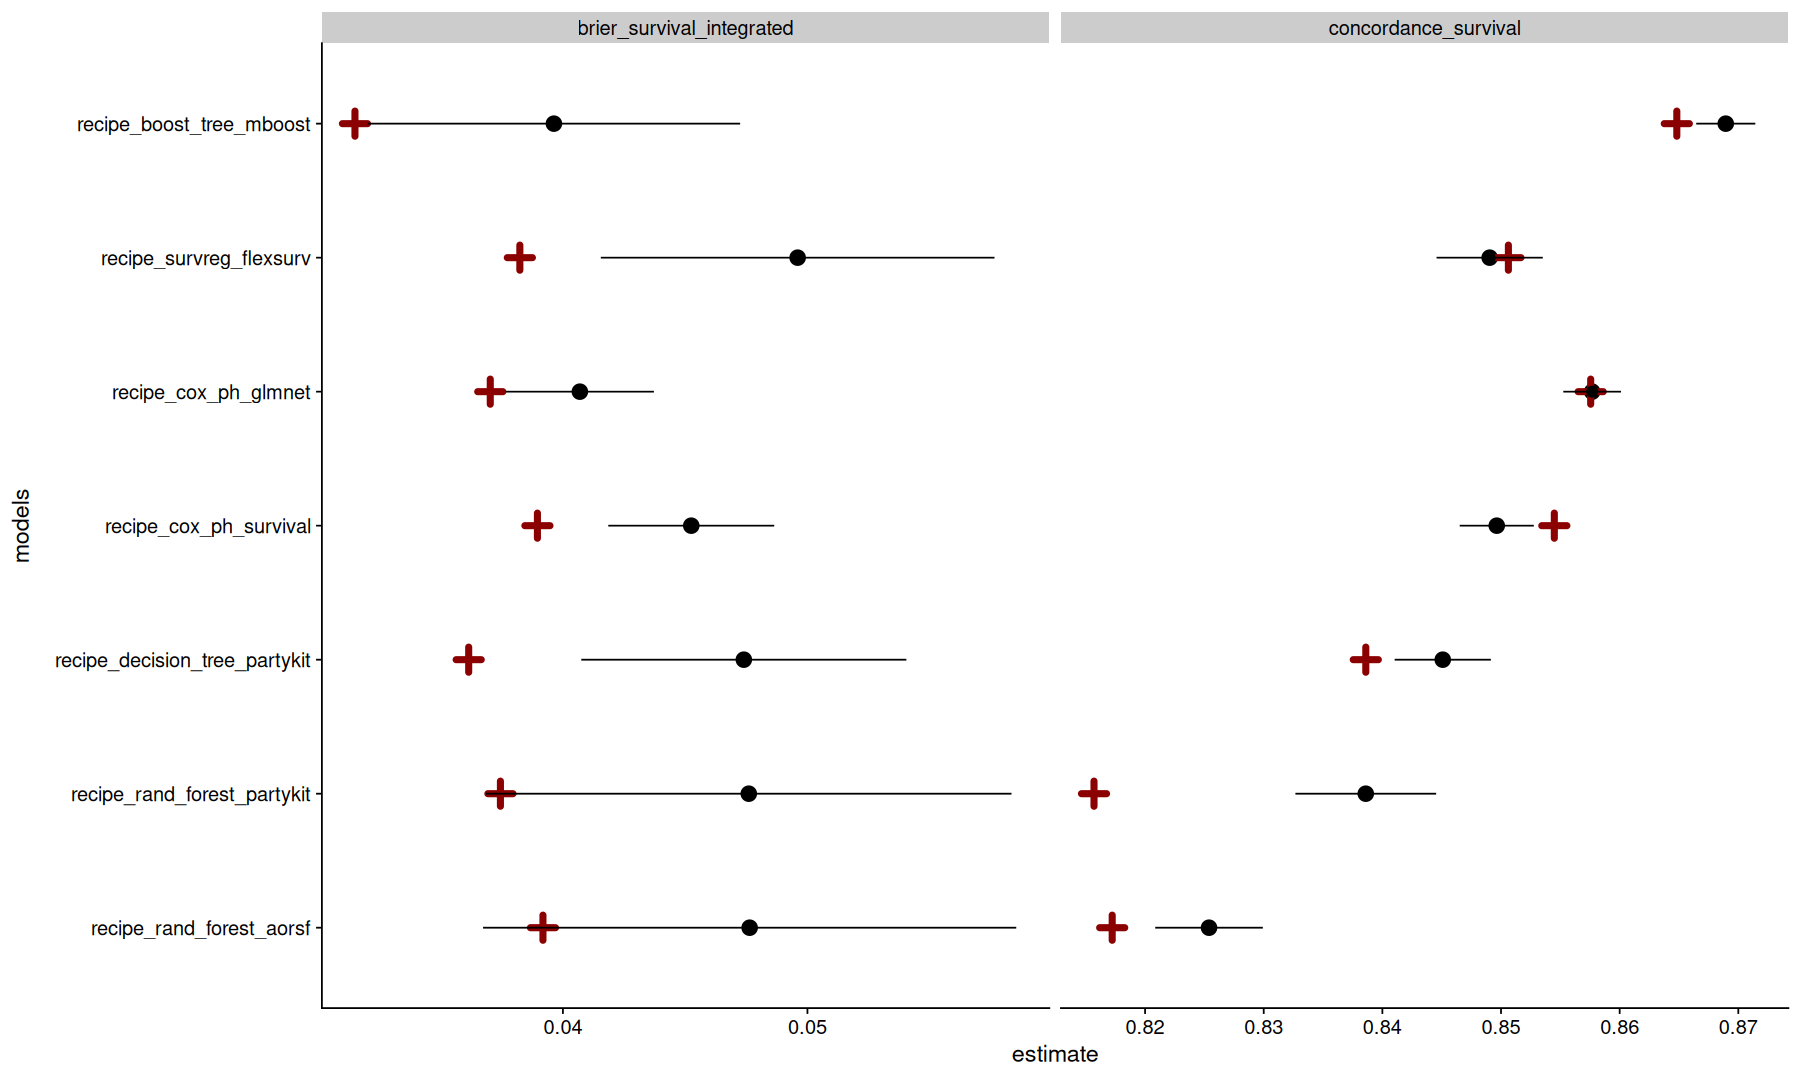

In [16]:
list_rbind(final_fits$metrics) |>
inner_join(tune_metrics) |>
filter(is.na(.eval_time)) |>
ggplot(aes(y=fct_reorder(wflow_id,mean), x=mean)) +
geom_point(size=4) +
geom_point(aes(x=.estimate), shape=3, size=3, stroke=3, color='darkred') +
geom_pointrange(aes(xmin=mean-std_err, xmax=mean+std_err)) +
labs(x='estimate', y='models') +
facet_wrap(~.metric, scales='free_x')

Joining with `by = join_by(.metric, .estimator, .eval_time, .config, wflow_id)`


[[1]]

[[2]]


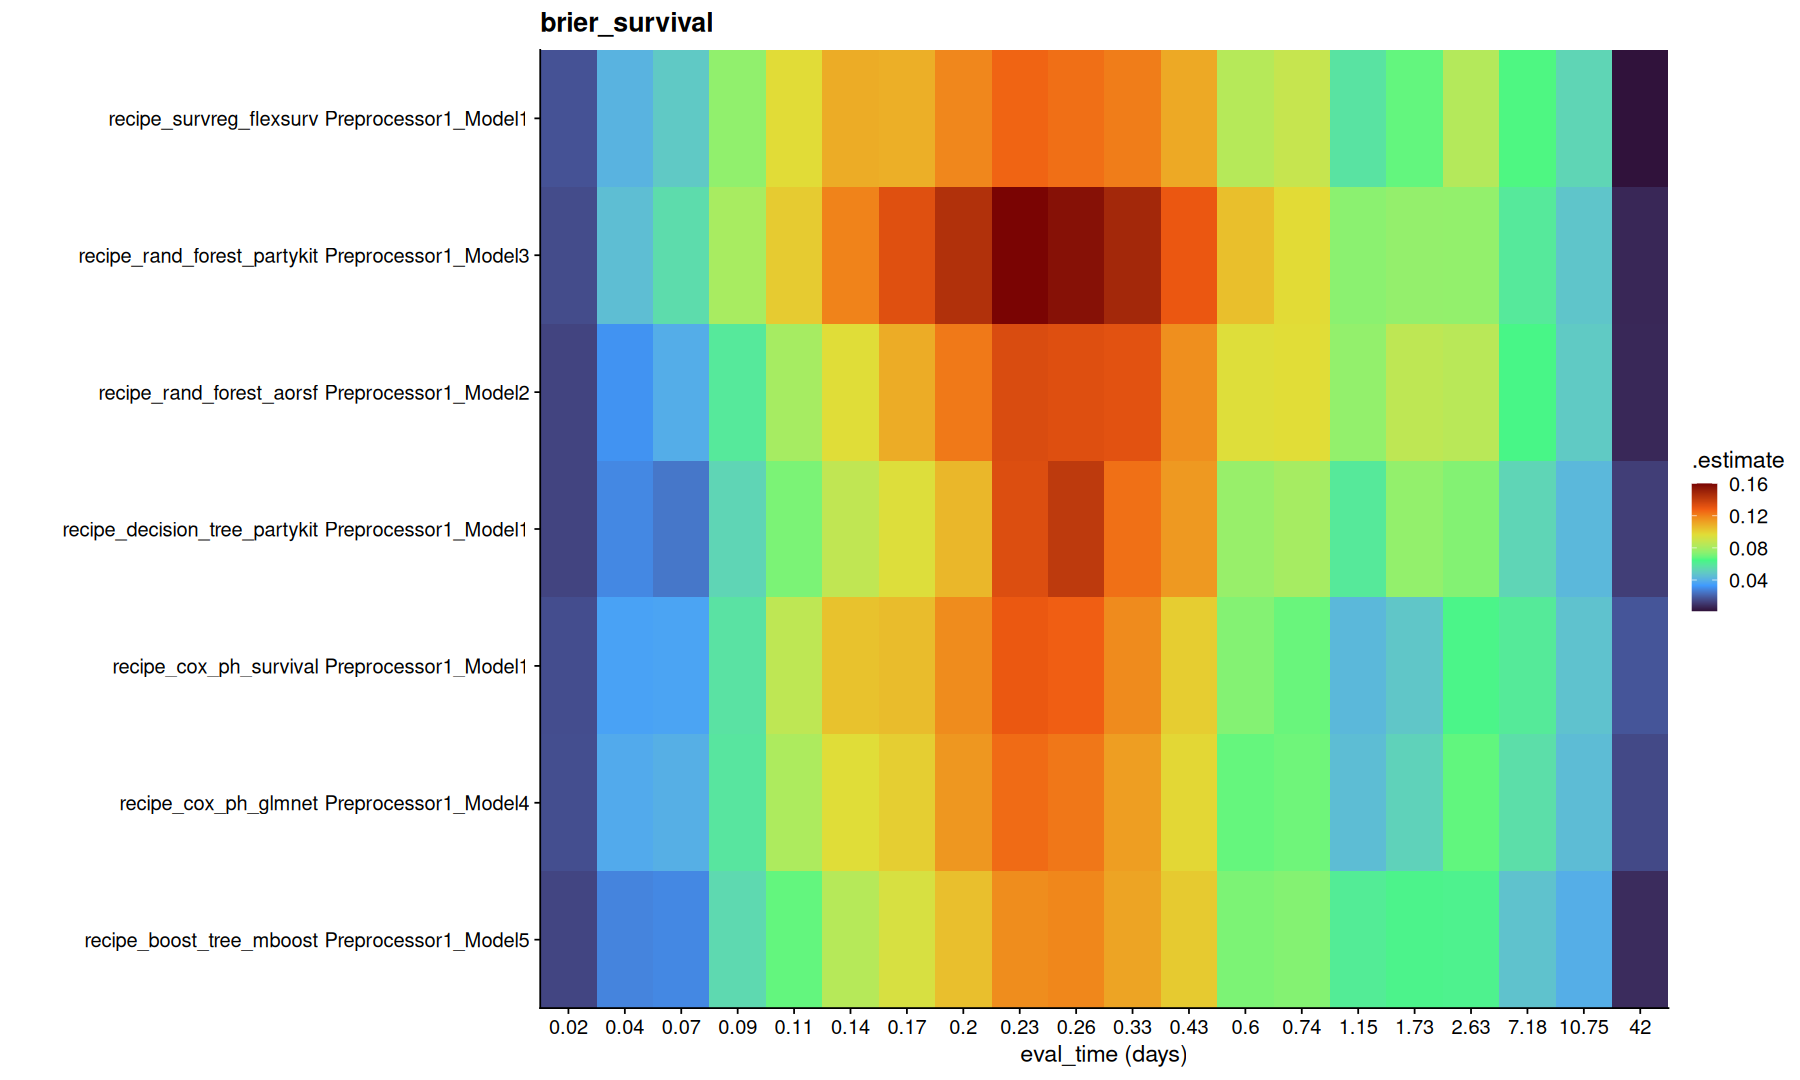

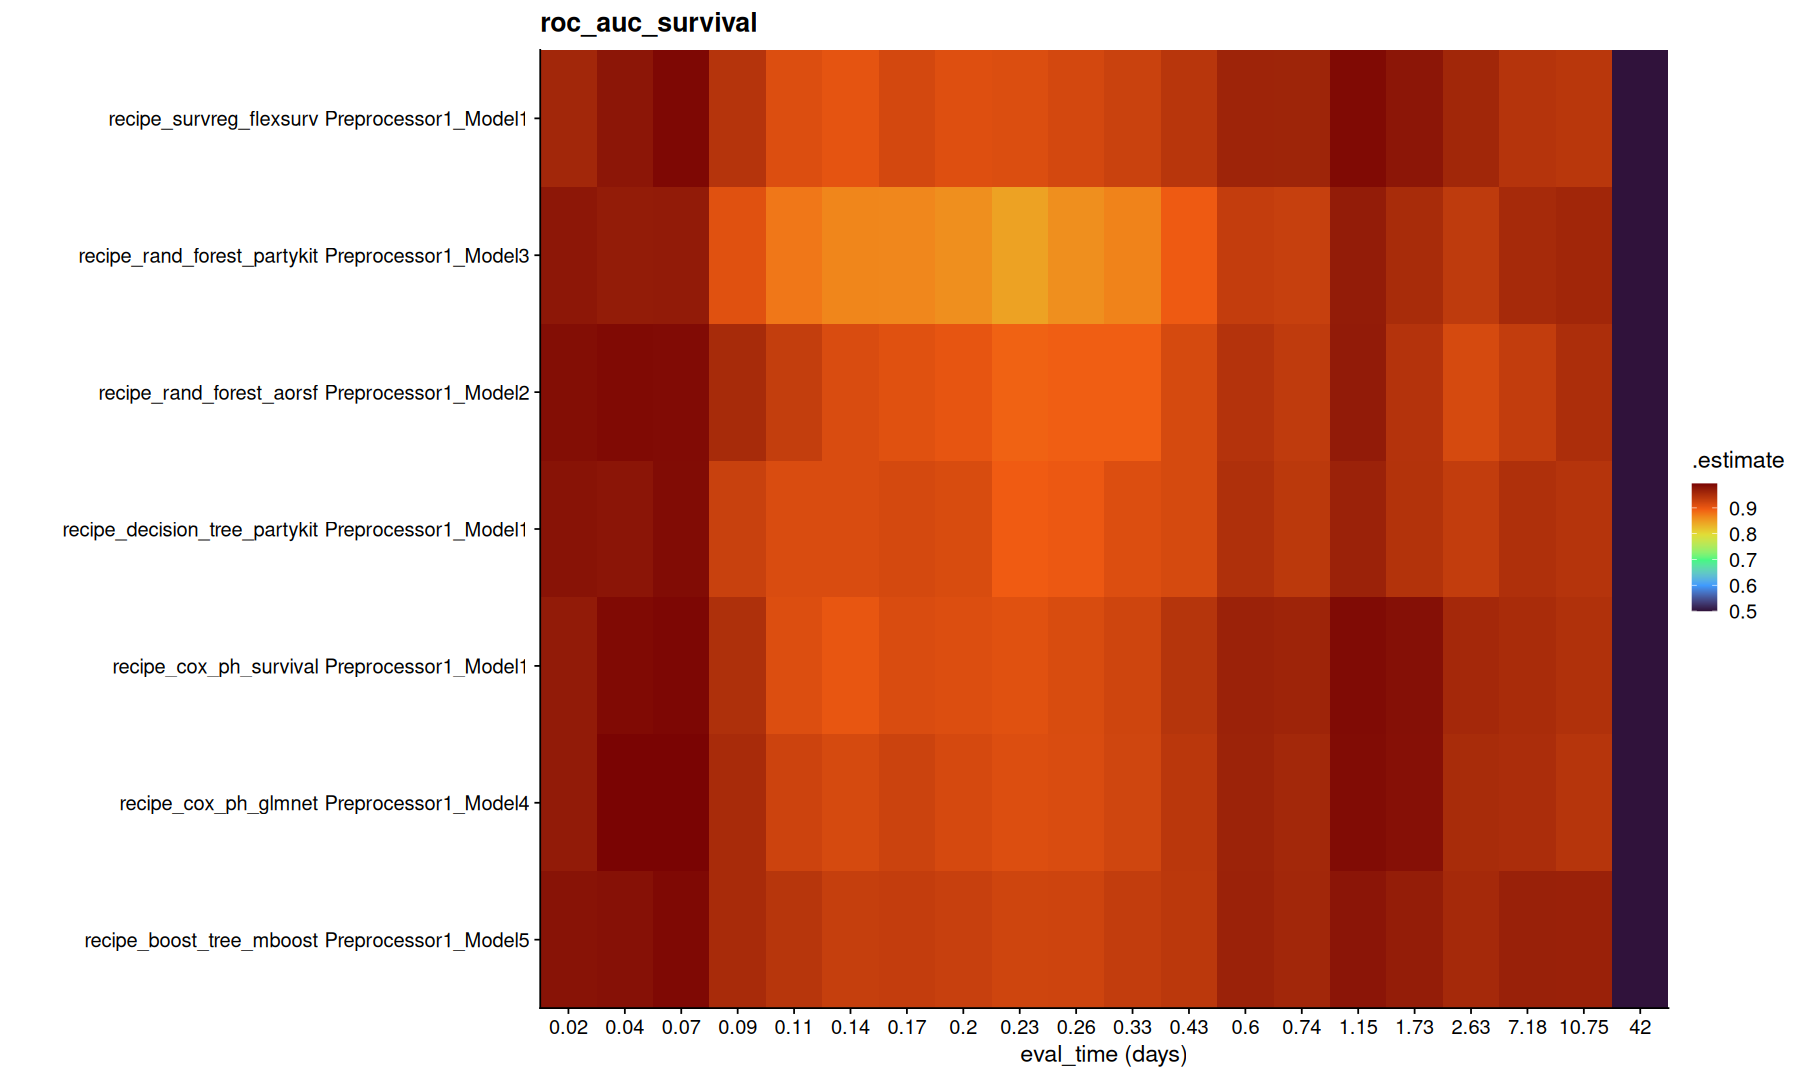

In [17]:
list_rbind(final_fits$metrics) |>
inner_join(tune_metrics) |>
filter(!is.na(.eval_time)) |>
group_by(.metric) |>
group_map(function(df, g) {
    ggplot(df,aes(x=factor(round(.eval_time,2)), y=paste(wflow_id, .config), fill=.estimate)) +
    geom_tile() +
    coord_cartesian(expand=0) +
    scale_fill_viridis_c(option='turbo') + labs(title=g, x='eval_time (days)', y='')
}) 

# Variable Importance

In [32]:
names(final_fits$fit)

[1] "recipe_cox_ph_survival"        "recipe_cox_ph_glmnet"         
[3] "recipe_survreg_flexsurv"       "recipe_rand_forest_partykit"  
[5] "recipe_rand_forest_aorsf"      "recipe_decision_tree_partykit"
[7] "recipe_boost_tree_mboost"

In [34]:
final_fits$fit[['recipe_cox_ph_glmnet']] |>
extract_spec_parsnip()

Proportional Hazards Model Specification (censored regression)

Main Arguments:
  penalty = 0.0238338401768485
  mixture = 0.843754897918552

Computational engine: glmnet 


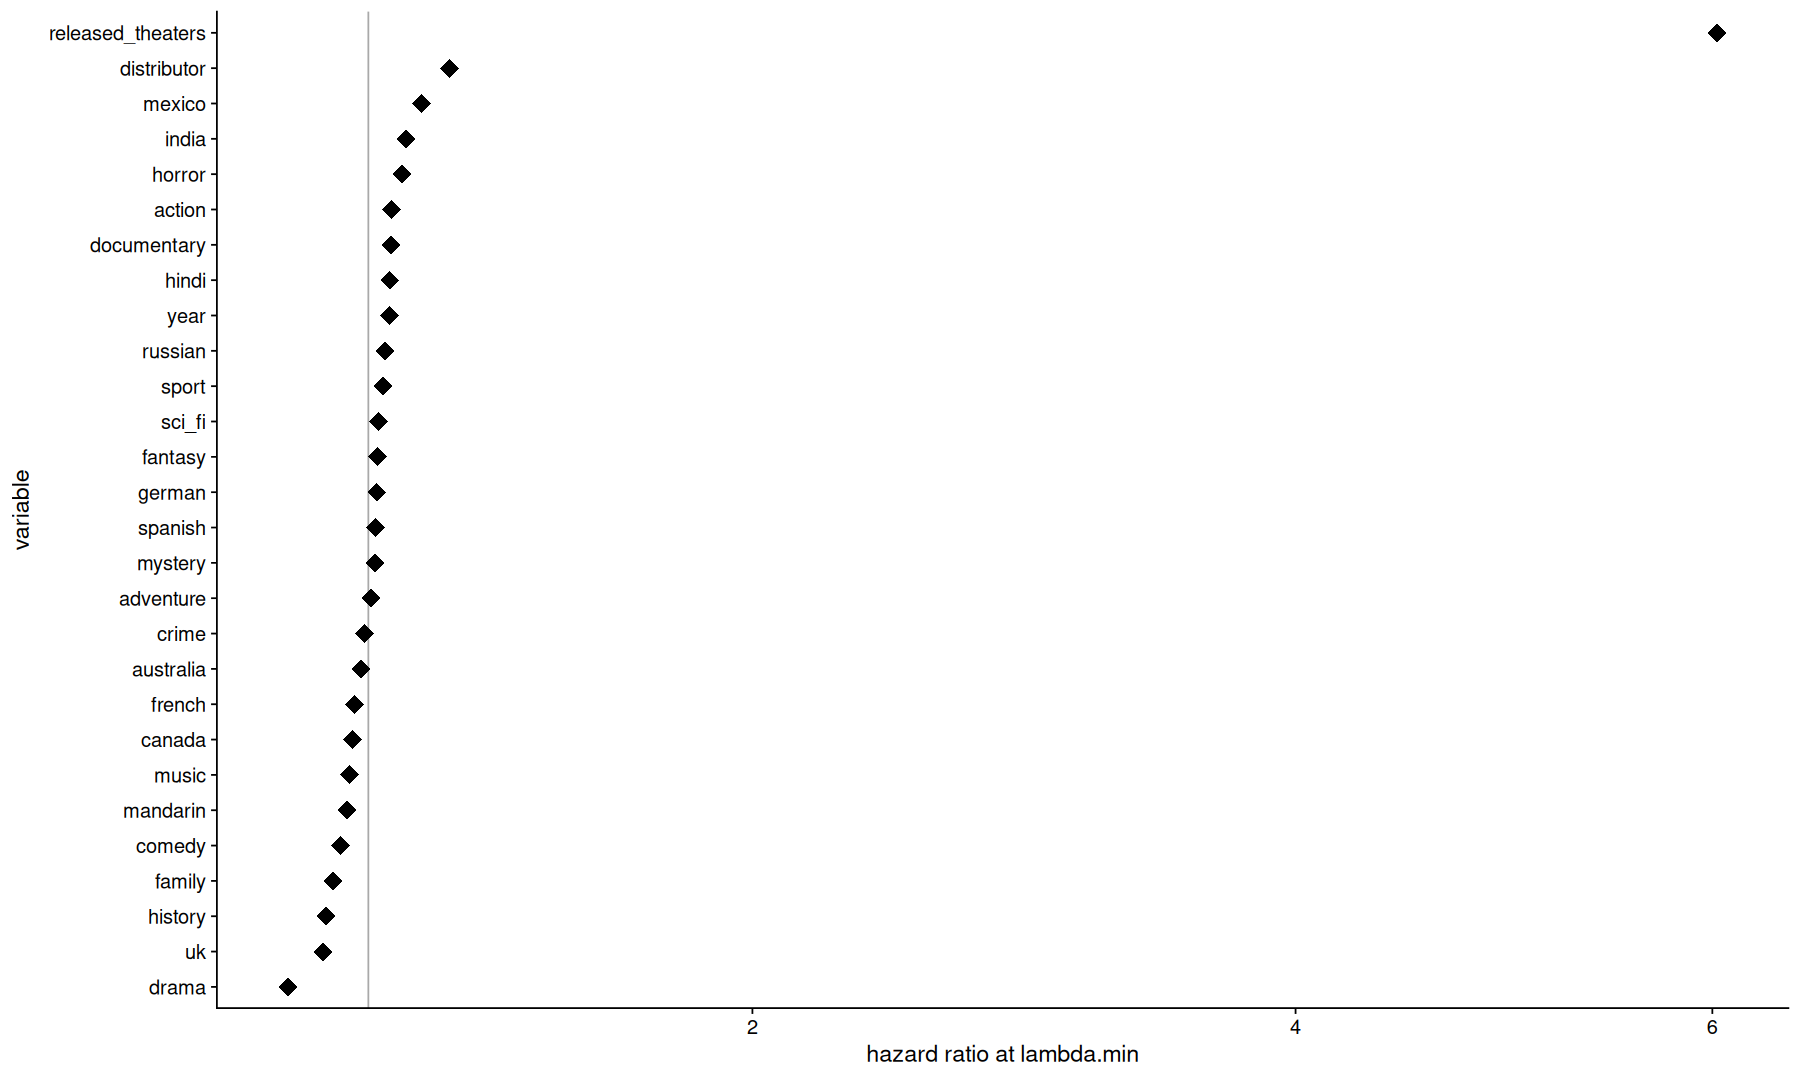

In [43]:
final_fits$fit[['recipe_cox_ph_glmnet']] |>
extract_fit_engine() |>
tidy() |>
filter(abs(lambda - 0.0238338401768485)<0.001) |>
mutate(exp.estimate=exp(estimate)) |>
ggplot(aes(x=exp.estimate, y=fct_reorder(term, estimate))) + 
geom_vline(xintercept=1, color='darkgray') +
geom_point(size=5, shape=18) +
scale_x_sqrt() +
labs(x='hazard ratio at lambda.min', y='variable')

In [44]:
final_fits$fit[['recipe_boost_tree_mboost']] |>
extract_spec_parsnip()

Boosted Tree Model Specification (censored regression)

Main Arguments:
  trees = 94

Computational engine: mboost 


In [71]:
mboost_obj <-
final_fits$fit[['recipe_boost_tree_mboost']] |>
extract_fit_parsnip()

In [52]:
prec <-
final_fits$fit[['recipe_boost_tree_mboost']] |>
extract_recipe()

In [60]:
train_data <-
bake(prec,new_data=training(data_split), all_predictors())

In [89]:
library(doFuture)
registerDoFuture()

In [90]:
shap.vals <- fastshap::explain(mboost_obj, X = head(train_data,100), nsim=100, pred_wrapper = function(obj,newdata) pull(predict(obj,new_data=newdata),.pred_time), shap_only=FALSE, parallel=TRUE)

Warning message:
"UNRELIABLE VALUE: One of the foreach() iterations ('doFuture-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, use '%dorng%' from the 'doRNG' package instead of '%dopar%'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, set option 'doFuture.rng.onMisuse' to "ignore"."
Warning message:
"UNRELIABLE VALUE: One of the foreach() iterations ('doFuture-2') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, use '%dorng%' from the 'doRNG' package instead of '%dopar%'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, set option 'doFuture.rng.onMisuse' to "ignore"."
Wa

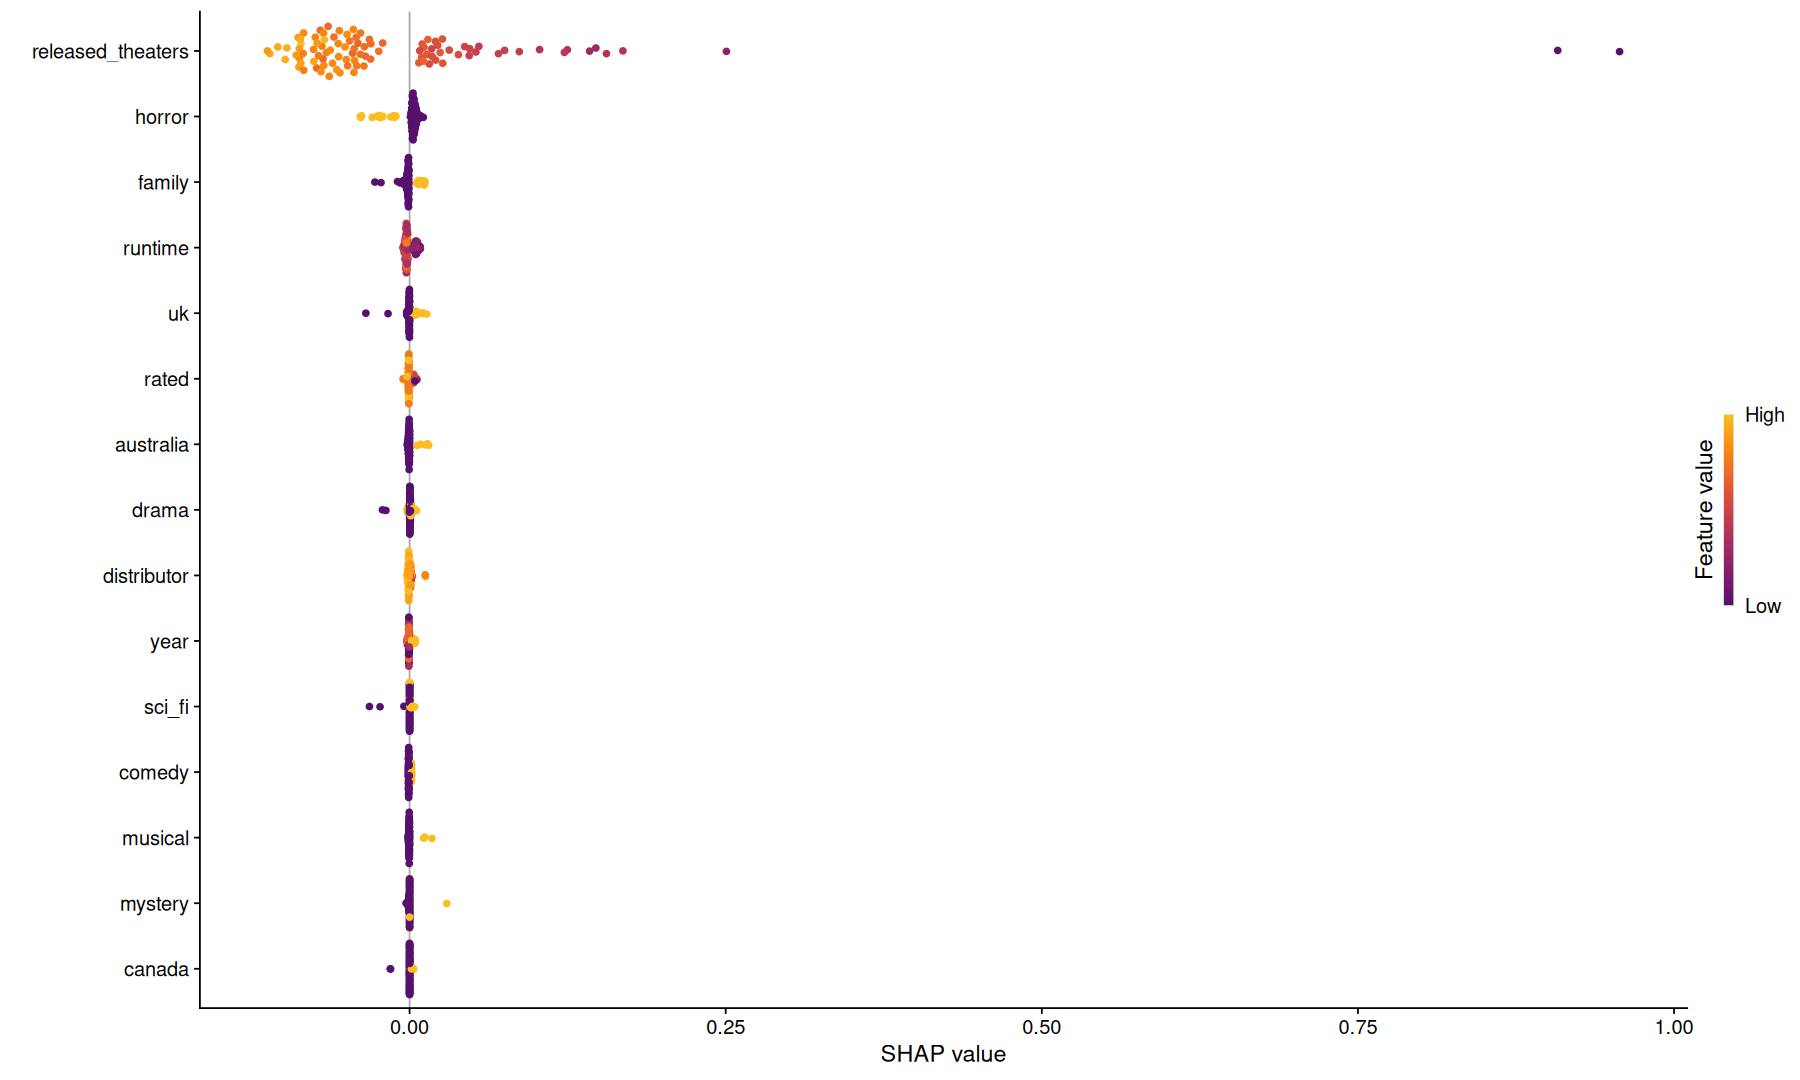

In [91]:
sv <- shapviz(shap.vals)
sv_importance(sv, kind = "beeswarm")

# Futher reading

* [Accounting for Censoring in Performance Metrics for Event Time Data](https://www.tidymodels.org/learn/statistics/survival-metrics-details/)
* [Dynamic Performance Metrics for Event Time Data](https://www.tidymodels.org/learn/statistics/survival-metrics/)
* [A survival analysis case study](https://www.tidymodels.org/learn/statistics/survival-case-study/)